### audio 데이터 읽어오기

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print("load audio data")

load audio data


In [3]:
#npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어있습니다.

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)



- 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이루어져 있다.


- 1초의 길이의 오디오 음성데이터는 각각 8000개의 sample data를 가지고 있는것을 확인할 수 있다.


### Spectrogram 데이터 변환
- 1차원이었던 waveform을 2차원의 spectrogram으로 변환해준다.

---

#### Spectrogram 변환 테스트

In [4]:
import librosa 

def wav_to_spec(wav, fft_size=258):  # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size)) # stft 함수는 복소수 행렬 D를 반환
    return D

- Spectrogram 데이터 변환 테스트

In [5]:
spec_test = np.abs(librosa.stft(speech_data["wav_vals"][0],n_fft=258))
print("Waveform shape : ",speech_data["wav_vals"][0].shape)
print("Spectrogram shape : ",spec_test.shape)
# 2차원으로 변환이 이루어졌다.

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


- Spectrogram 시각화로 데이터가 잘 들어왔는지 확인

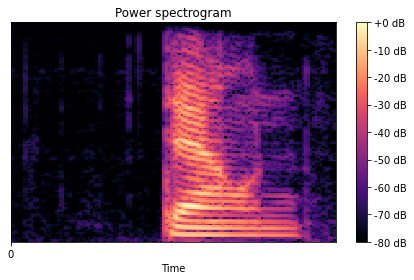

In [6]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec_test, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()


### Wav To Spectrogram 변환 
- 1차원인 wav 음성 데이터를 Spectrogram으로 변환

In [7]:
from tqdm import tqdm
spec= []
spec_len = 35000 # Spectrogram으로 변환하고 사용할 데이터 개수 [label과 공통 값]
# 35000 이상까지는 메모리의 부담이 크다

for sp in tqdm(speech_data["wav_vals"][:spec_len]):  
    spec.append(wav_to_spec(sp))

spec_data = np.array(spec)  # ndarray로 변환
# spec_data

100%|██████████| 35000/35000 [00:25<00:00, 1375.06it/s]


### Plt 시각화로 spectrogram 변환 확인
- 무작위의 값을 추출해서 스펙트로그램으로 변환이 잘 이루어 졌는지 확인한다.

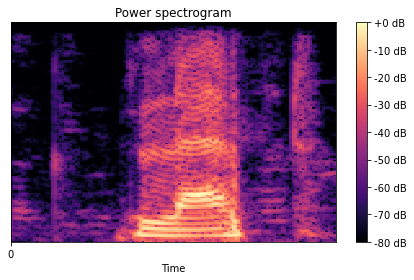

5290번 스펙트로그램


In [8]:
import librosa.display
import matplotlib.pyplot as plt
import random
# 스펙트로그램에 포함된 랜덤 데이터 이미지 출력
rand = random.randint(0, len(spec_data)) 
librosa.display.specshow(librosa.amplitude_to_db(spec_data[rand], ref=np.max), x_axis='time')

plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()
print("{}번 스펙트로그램".format(rand))

### 라벨 데이터 처리
- 라벨 데이터 학습을 위해 사전 형식으로 변환 및 각 Label에 대한 인덱스 값 부여

In [9]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):  # 라벨 데이터 학습을 {label:index} 형태로 변환
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

# ndarray 형식으로 변환

tmp = []
for speech in speech_data["label_vals"][:spec_len] :
        tmp.append(label_value[speech[0]])
label_data = np.array(tmp)


LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [10]:
# ndarray 형식으로 변환
label_data

array([3, 3, 3, ..., 5, 5, 5])

### Train/Test 데이터로 분리

In [12]:
spec_data.shape

(35000, 130, 126)

In [13]:
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

In [14]:
print(train_wav.shape)

(31500, 130, 126)


- 1D-CNN 모델 사용을 위한 채널 추가

In [13]:
train_wav = train_wav.reshape([-1, 130, 126,1]) # CNN을 위한 채널 추가
test_wav = test_wav.reshape([-1, 130, 126,1])

print("\ntrain/test reshape complete")



train/test reshape complete


- 1D-CNN 사용을위해 1차원을 의미하는 1을 추가한다.  (130,126,1) or (130,126,)
  - 그렇지만 1차원이여서 (130,126) 데이터 그대로 사용해도 괜찮다.


#### train/test 데이터 확인 

In [15]:
# data셋의 test_size 크기 만큼 테스트 데이터가 생성되었다.
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (31500, 130, 126, 1)
train labels :  (31500,)
test data :  (3500, 130, 126, 1)
test labels :  (3500,)


### 학습을 위한 하이퍼파라미터 설정

- batch_size, epochs 지정


- 모델의 가중치를 저장 할 check point 위치 지정

In [14]:
batch_size = 16  # 32할 시 소요 시간이 너무 크다.
epochs = 9     # 반복횟수 12으로 지정

# check point 지정
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac27/aiffel/speech_recognition/models/wav'

### audio 데이터 셋 구성

- tf.data.Dataset을 이용해서 데이터셋을 구성


- map 함수를 활용해 dataset이 데이터를 load할 때마다 데이터 전처리 함수를 매핑


#### 데이터 전처리 함수 구성

In [16]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12) # 카테고리의 개수만큼 depth를 설정
                                        # 해당 범주에 맞는 값은 1 나머지는 0으로 데이터 처리
    return wav, label


- **tf.data.Dataset으로 train/test 데이터 셋 구성**


- from_tensor_slices 함수에 return 받길 원하는 데이터 튜플(data, label)형태로 넣어서 사용
  - 위의 전처리 함수인 one_hot_label(wav, label)에서도 튜플로 입력 받고 튜플로 반환한다.<br> tf.data.Dataset -> 튜플 형태
  
  
- **One-hot Encoding** 범주형 데이터뿐만 아니라 분류 문제에서 학습에 사용되는 정답 데이터와 감성 분석이나 텍스트 생성 모델을 만들 때도 사용한다.
  

In [17]:
import tensorflow as tf
tf.random.set_seed(19)
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
# train data : map, batch 데이터 전처리
train_dataset = train_dataset.map(one_hot_label)  
# map를 써서 데이터를 one_hot_label함수에 넣는다. 
# true일 경우 1 아닐 경우 0
# 컴퓨터가 확실한 판단을 내리는데 도움을 준다.
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print("train_dataset : ", train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
# test data : map, batch 데이터 전처리
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print("test_dataset : ", test_dataset)


train_dataset :  <BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
test_dataset :  <BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


---

### Spectrogram 데이터 처리 모델 구성
- Conv1D로 구성 [spec_data.shape[1:]]


- Dropout, BatchNormalization 활용

In [40]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(spec_data.shape[1:])) # spec_data shape를 Input한다.

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.2)(x) # 과적합(overfitting) 방지

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# layer의 층이 깊으므로 Batch Normalization 사용
# 평균과 분산을 구한 후 정규화 시켜준다.[-1 ~1의 범위] 후 scale & shift연산
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 130, 32)           36320     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 65, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 65, 64)            18496     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 64)            0   

In [41]:
# speech_data 사용할 일이 없으니
# del로 메모리 버퍼 비워주기
# wav데이터
del speech_data
del spec_data

#### Loss
- 다양한 유형의 Label class를 사용하므로, multi-class classification을 사용해야 한다.
- Categorical cross-Entropy Loss 사용

In [42]:
from tensorflow.keras.optimizers import Adam
model_wav.compile(optimizer=Adam(lr=0.001, epsilon=1e-4),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
model_wav

#### Callback

- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있다.


- 모델을 재사용하기위해서 모델 가중치를 저장하는 callback.ModelCheckpoint 함수를 사용

In [43]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("check point 설정")

check point 설정


### 모델 학습 
- model.fit으로 모델 학습 시작
- Hyperparameter은 위에 이미 정의 해둔 epochs, batch_size 사용

In [44]:
# 메모리 사용량에 주의
batch_size = 16
epochs = 9 
history_wav = model_wav.fit(train_dataset, epochs=epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("model training complete")

Epoch 1/9
1960/1968 [============================>.] - ETA: 0s - loss: 1.8889 - accuracy: 0.2936
Epoch 00001: val_loss improved from inf to 1.77241, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 11s 6ms/step - loss: 1.8882 - accuracy: 0.2938 - val_loss: 1.7724 - val_accuracy: 0.4054
Epoch 2/9
1965/1968 [============================>.] - ETA: 0s - loss: 1.2853 - accuracy: 0.5545
Epoch 00002: val_loss improved from 1.77241 to 0.95821, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 11s 6ms/step - loss: 1.2853 - accuracy: 0.5545 - val_loss: 0.9582 - val_accuracy: 0.6666
Epoch 3/9
1959/1968 [============================>.] - ETA: 0s - loss: 0.8288 - accuracy: 0.7235
Epoch 00003: val_loss improved from 0.95821 to 0.71037, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 11s 6ms/step - loss: 0.8290 - accu

#### 학습 결과 그래프로 확인

- plot을 사용해서 모델의 학습이 어떻게 진행되었는지 확인할 수 있다.

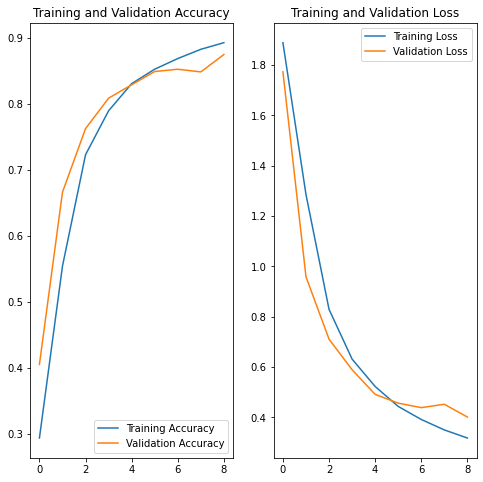

✅


In [45]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

#### Model Evaluation
- Test Dataset으로 모델이 잘학습되었는지 평가한다.


- checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비

In [46]:
# weight 불러오기
model_wav.load_weights(checkpoint_dir)
checkpoint_dir

'/home/ssac27/aiffel/speech_recognition/models/wav'

In [47]:
# model evaluate
results = model_wav.evaluate(test_dataset) # test dataset로 model 학습이 잘 이루어 졌는데 확인
results

219/219 [==============================] - 21s 95ms/step - loss: 0.4011 - accuracy: 0.8751


[0.4011472463607788, 0.8751428723335266]

In [48]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.401
accuracy value: 87.5143%


#### Model Test
- 랜덤한 데이터를 추출한 후 라벨링 값과 모델의 실제 prediction 라벨링 값을 확인


In [52]:
import random

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)
# test data 에서 랜덤한 데이터 인덱스 변수에 넣기

batch_xs = test_wav[batch_index]   # 해당 인덱스를 가진 test 데이터
batch_ys = test_label[batch_index]  # 해당 인덱스를 가진 test 라벨

y_pred_ = model_wav(batch_xs, training=False)  
# training=False 하는 경우  BatchNormalization: 출력을 정규화 한다. 
# True로 할 경우 다르게 예측한 값이 주로 나오며, False로 할 경우 올바르게
# 예측한 값이 나온다.

print("label : ", str(inv_label_value[batch_ys[0]]))
print("model_prdeict :", str(inv_label_value[np.argmax(y_pred_)]) )
# np.argmax : 리스트의 인덱스 중 가장 큰 값을 가진 인덱스를 반환한다.
# [0, 2,4,3] -> np.argmax([0, 2,4,3]) => 4를 반환한다.

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  no
model_prdeict : no
y_pred: no(Correct!)


In [53]:
print(y_pred_[0])
print("\n y_pred :",np.argmax(y_pred_))

tf.Tensor(
[ -4.3572197   5.99667    -4.73695     1.523046   -0.4885283  -5.050494
  -3.4772308  -2.521745   -3.2708275   2.904057  -12.798531  -13.5706415], shape=(12,), dtype=float32)

 y_pred : 1


---


##  Skip-Connection 활용 model 구현
- Skip-connection이란, 위쪽의 데이터가 아래의 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현된다.


-  Skip-Connection model 사용했을때 모델의 성능이 더 좋아지는지 확인해 보자.

- tensorflow의 concat 라이브러리를 활용하여 skip-connection을 구현할 수 있다.


#### code Exampel)
``` python
skip_Connection_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_Connection_1)
x = tf.concat([x, skip_Connection_1], -1)

skip_Connection_2 = layers.MaxPool1D()(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_Connection_2)
x = tf.concat([x, skip_Connection_2], -1)

...
```



In [18]:
from tensorflow.keras import layers
# Skip-Connection 사용 모델
input_tensor = layers.Input(shape=(spec_data.shape[1:])) # spec_data shape를 Input한다.

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_Connection_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_Connection_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_Connection_1], -1) # tf.concat : tensor데이터를 횡 방향으로 연결
skip_Connection_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_Connection_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_Connection_2], -1)
skip_Connection_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_Connection_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_Connection_3], -1)
x = layers.MaxPool1D()(x)

x = layers.Dropout(0.3)(x)# 과적합(overfitting) 방지

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# layer의 층이 깊으므로 Batch Normalization 사용
# 평균과 분산을 구한 후 정규화 시켜준다.[-1 ~1의 범위] 후 scale & shift연산
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 130, 32)      36320       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 130, 32)      9248        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 65, 32)       0           conv1d_1[0][0]                   
______________________________________________________________________________________________

### Loss
- 다양한 유형의 Label class를 사용하므로, multi-class classification을 사용해야 한다.


- Categorical cross-Entropy Loss 사용

In [19]:
# 최적화로 Adam사용
# loss로 CategoricalCrossentropy 사용
from tensorflow.keras.optimizers import Adam
model_wav.compile(optimizer=Adam(lr=0.001, epsilon=1e-4),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
model_wav

### Callback

- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있다.


- 모델을 재사용하기위해서 모델 가중치를 저장하는 callback.ModelCheckpoint 함수를 사용

In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("check point 설정")

check point 설정


### 모델 학습 
- model.fit으로 모델 학습 시작
- Hyperparameter은 위에 이미 정의 해둔 epochs, batch_size 사용

In [21]:
# 메모리 사용량에 주의
batch_size = 16
epochs = 9 
history_wav = model_wav.fit(train_dataset, epochs=epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("model training complete")

Epoch 1/9
1968/1968 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.5324
Epoch 00001: val_loss improved from inf to 0.82803, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 12s 6ms/step - loss: 1.3458 - accuracy: 0.5324 - val_loss: 0.8280 - val_accuracy: 0.7222
Epoch 2/9
1959/1968 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.7744
Epoch 00002: val_loss improved from 0.82803 to 0.45998, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 12s 6ms/step - loss: 0.6713 - accuracy: 0.7748 - val_loss: 0.4600 - val_accuracy: 0.8460
Epoch 3/9
1965/1968 [============================>.] - ETA: 0s - loss: 0.4943 - accuracy: 0.8352
Epoch 00003: val_loss improved from 0.45998 to 0.42532, saving model to /home/ssac27/aiffel/speech_recognition/models/wav
1968/1968 [==============================] - 12s 6ms/step - loss: 0.4943 - accu

#### 학습 결과 그래프로 확인

- plot을 사용해서 모델의 학습이 어떻게 진행되었는지 확인할 수 있다.

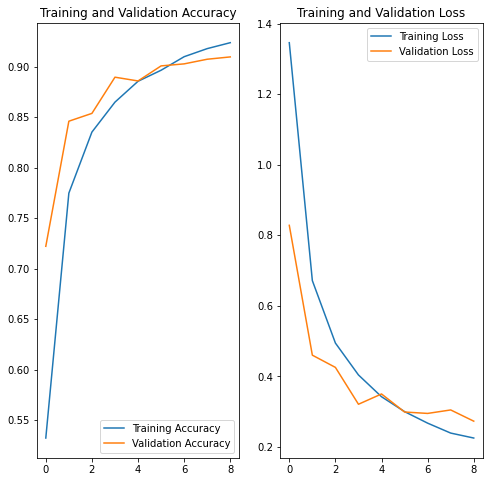

✅


In [22]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### Model Evaluation
- Test Dataset으로 모델이 잘학습되었는지 평가한다.


- checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비

In [23]:
# weight 불러오기
model_wav.load_weights(checkpoint_dir)
checkpoint_dir

'/home/ssac27/aiffel/speech_recognition/models/wav'

In [24]:
# model evaluate
results = model_wav.evaluate(test_dataset) # test dataset로 model 학습이 잘 이루어 졌는데 확인
results

219/219 [==============================] - 15s 69ms/step - loss: 0.2740 - accuracy: 0.9094


[0.2739584147930145, 0.909428596496582]

In [25]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.274
accuracy value: 90.9429%


---
### Model Test
- 랜덤한 데이터를 추출한 후 라벨링 값과 모델의 실제 prediction 라벨링 값을 확인


In [26]:
import random

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)
# test data 에서 랜덤한 데이터 인덱스 변수에 넣기

batch_xs = test_wav[batch_index]   # 해당 인덱스를 가진 test 데이터
batch_ys = test_label[batch_index]  # 해당 인덱스를 가진 test 라벨

y_pred_ = model_wav(batch_xs, training=False)  
# training=False 하는 경우  BatchNormalization: 출력을 정규화 한다. 
# True로 할 경우 다르게 예측한 값이 주로 나오며, False로 할 경우 올바르게
# 예측한 값이 나온다.

print("label : ", str(inv_label_value[batch_ys[0]]))
print("model_prdeict :", str(inv_label_value[np.argmax(y_pred_)]) )
# np.argmax : 리스트의 인덱스 중 가장 큰 값을 가진 인덱스를 반환한다.
# [0, 2,4,3] -> np.argmax([0, 2,4,3]) => 4를 반환한다.

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  off
model_prdeict : off
y_pred: off(Correct!)


In [27]:
print(y_pred_[0])
print("\n y_pred :",np.argmax(y_pred_))

tf.Tensor(
[ -5.7749667  -4.4573812  -2.310232   -3.6511555  -8.56735    -2.5419114
   4.0664406   6.350058   -2.528771   -3.9849463 -12.991879  -13.329288 ], shape=(12,), dtype=float32)

 y_pred : 7


In [28]:
print("모델 예측 인덱스 : ",np.argmax(y_pred_))

print("실제 데이터를 가져온 라벨의 인덱스 : ",batch_ys[0])

모델 예측 인덱스 :  7
실제 데이터를 가져온 라벨의 인덱스 :  7


---

### Skip-Connection 사용 유/무에 따른 모델 차이

In [48]:
# Skip-Connection 활용하지 않은 모델
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.401
accuracy value: 87.5143%


In [29]:
# Skip-Connection 활용 모델
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.274
accuracy value: 90.9429%


#### skip-connection을 사용하고 모델의 loss값이 크게 감소, accuracy가 소폭 상승한 것을 볼 수 있다.

---

### 회고

- 음성 데이터를 사용해서 직접 소리를 들어보고 모델이 맞다고 한게 진짜 맞는지 직접 확인할 수 있다는 점이 신선하면서 재밌었습니다.


- 네이버에 있는 노래 들려주고 음원 찾아주는 서비스가 어떻게 가능한지 간접적으로 체험할 수 있어서 신기하기도 했습니다.


- 재밌고 신선하게 다가왔지만, 음향의 이론 부분이 다소 어려운 점만 제외하면 재밌게 진행한것 같습니다.


- 그리고 이번 프로젝트를 진행하면서 느낀점은 모델 학습을 진행할때 1D-CNN말고 다른 모델을 사용해서 진행해보려 했지만 생각보다 잘 되지 않았습니다. <br> 그간 몇번 모델의 구조를 만들면서 딥러닝 모델의 이해가 충분한것 같다고 생각했지만 이번에 진행하면서 아직 부족함을 느낀것 같습니다.

---